# Performance of Foster's CIR solver vs the Drift-implicit Euler scheme applied to the CIR process

We compare the performance of the two solvers on two examples of the CIR process, an easier one and a stiffer one. We also compare adaptive step size control with a fixed step size.

## Summary of results
Medium-volatility CIR (a=1, b=1, sigma=1.5):
- HOStS non-adaptive: 0.7824
- HOStS adaptive: 1.8225
- DriftImplicitEuler non-adaptive: 0.8618
- DriftImplicitEuler adaptive: 1.0269

High-volatility CIR (a=1, b=1, sigma=2.2):
- HOStS non-adaptive: 0.3944
- HOStS adaptive: 0.8092
- DriftImplicitEuler non-adaptive: 0.4642
- DriftImplicitEuler adaptive: 0.8618

In [5]:
from typing import Optional


%env JAX_PLATFORM_NAME=cuda

from test.helpers import get_cir, simple_sde_order

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd
from diffrax import (
    diffeqsolve,
    DriftImplicitEulerCIR as DIE,
    HOStS,
    SaveAt,
)
from diffrax._step_size_controller.cir_adaptive import CIRController
from drawing_and_evaluating import (
    draw_order_multiple,
    load_order_results,  # noqa: F401
    plot_sol_general,  # noqa: F401
    remove_steps,
    save_order_results,  # noqa: F401
)
from jax import config


config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", "{:.3}".format)


def cir_strong_order(keys, sde, solver, levels, bm_tol=None):
    def get_controller(level):
        return CIRController(
            ctol=2**-level,
            dtmin=2**-15,
            dtmax=1.0,
        )

    if bm_tol is None:
        bm_tol = 2**-16
    return simple_sde_order(
        keys, sde, solver, solver, levels, get_controller, SaveAt(t1=True), bm_tol
    )


def print_stats(
    steps_errs_ord: tuple,
    _tols: Optional[jnp.ndarray],
):
    num_steps, errs, order = steps_errs_ord
    column_names = ["num_steps", "errs"]
    columns = [num_steps, errs]
    if _tols is not None:
        tols_pow_hs = jnp.power(_tols, 2 / 3) * num_steps
        columns.extend([_tols, _tols / errs, _tols * num_steps, tols_pow_hs])
        column_names.extend(["tols", "tols/errs", "tols/hs", "tols^(2/3)/hs"])
    _table = jnp.stack(columns, axis=1)
    # Now use pandas to nicely print the table with the headers
    table = pd.DataFrame(_table, columns=column_names)
    print(table)


dtype = jnp.float64
num_samples = 50000
bm_key = jr.PRNGKey(2)
keys = jr.split(jr.PRNGKey(5678), num=num_samples)


def ctols(levels):
    return jnp.power(2.0, -jnp.arange(levels[0], levels[1] + 1, dtype=dtype))


def get_dtype(x):
    if type(x) in [int, float, str]:
        return type(x)
    else:
        return jnp.dtype(x)


t0, t1 = 0.0, 16.0
t_short = 4.0
t_long = 32.0
saveat = SaveAt(steps=True)
dt0 = 1 / 8
levels_const = (3, 11)
levels_adap = (0, 10)
levels_hard_adap = (1, 9)


args = (1.0, 1.0, 1.5)
print(f"tilde_b: {args[1] - (args[2]**2)/(4.0 * args[0])}")
cir = get_cir(t0, t1, args, dtype=dtype)
terms_cir = cir.get_terms(cir.get_bm(bm_key, levy_area="space-time", tol=2**-12))
cir_short = get_cir(t0, t_short, args, dtype=dtype)
args_hard = (1.0, 1.0, 2.2)
cir_hard = get_cir(t0, t_short, args_hard, dtype=dtype)
terms_cir_hard = cir_hard.get_terms(
    cir_hard.get_bm(bm_key, levy_area="space-time", tol=2**-14)
)
print(f"tilde_b_hard: {args_hard[1] - (args_hard[2]**2)/(4.0 * args_hard[0]):.2}")

env: JAX_PLATFORM_NAME=cuda
tilde_b: 0.4375
tilde_b_hard: -0.21


## Easy problem with medium volatility and positive tilde_b
a=1, b=1, sigma=1.5

In [2]:
# hosts_easy_const = constant_step_strong_order(keys, cir_short, HOStS(), levels_const)
# save_order_results(hosts_easy_const, "hosts_easy_const")
hosts_easy_const = load_order_results("hosts_easy_const")

# hosts_easy_adap = cir_strong_order(keys, cir_short, HOStS(), levels_adap)
# save_order_results(hosts_easy_adap, "hosts_easy_adap")
hosts_easy_adap = load_order_results("hosts_easy_adap")

# die_easy_const = constant_step_strong_order(keys, cir_short, DIE(), levels_const)
# save_order_results(die_easy_const, "die_easy_const")
die_easy_const = load_order_results("die_easy_const")

# die_easy_adap = cir_strong_order(keys, cir_short, DIE(), (0, 11))
# save_order_results(die_easy_adap, "die_easy_adap")
die_easy_adap = load_order_results("die_easy_adap")

Loaded order_results/order_results_hosts_easy_const.npy
Loaded order_results/order_results_hosts_easy_adap.npy
Loaded order_results/order_results_die_easy_const.npy
Loaded order_results/order_results_die_easy_adap.npy


In [3]:
hosts_easy_adap = remove_steps(hosts_easy_adap, 0, 1)

11


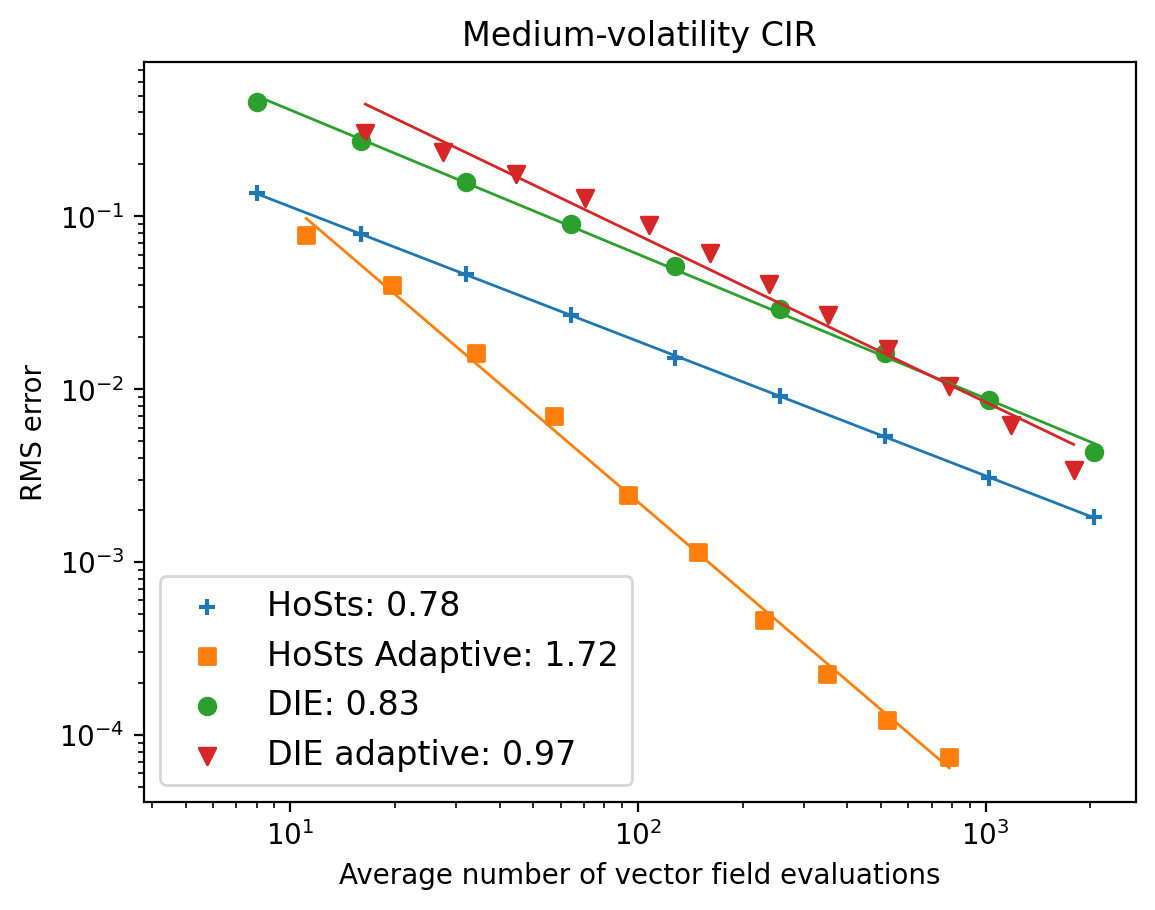

In [4]:
fig = draw_order_multiple(
    [hosts_easy_const, hosts_easy_adap, die_easy_const, die_easy_adap],
    ["HoSts", "HoSts Adaptive", "DIE", "DIE adaptive"],
    "Medium-volatility CIR",
)
fig.savefig("graphs/medium_volatility_cir.png")
fig.savefig("graphs/medium_volatility_cir.pdf")

## Hard problem with high volatility and negative tilde_b
a=1, b=1, sigma=2.2

In [6]:
lvl_hard_const = (5, 12)

# hosts_hard_const = constant_step_strong_order(
#     keys, cir_hard, HOStS(), lvl_hard_const)
# save_order_results(hosts_hard_const, "hosts_hard_const")
hosts_hard_const = load_order_results("hosts_hard_const")

# hosts_hard_adap = cir_strong_order(keys, cir_hard, HOStS(), levels_hard_adap)
# save_order_results(hosts_hard_adap, "hosts_hard_adap")
hosts_hard_adap = load_order_results("hosts_hard_adap")

# die_hard_const = constant_step_strong_order(keys, cir_hard, DIE(), lvl_hard_const)
# save_order_results(die_hard_const, "die_hard_const")
die_hard_const = load_order_results("die_hard_const")

# die_hard_adap = cir_strong_order(keys, cir_hard, DIE(), levels_hard_adap)
# save_order_results(die_hard_adap, "die_hard_adap")
die_hard_adap = load_order_results("die_hard_adap")

hosts_hard_adap = remove_steps(hosts_hard_adap, 0, 1)

Loaded order_results/order_results_hosts_hard_const.npy
Loaded order_results/order_results_hosts_hard_adap.npy
Loaded order_results/order_results_die_hard_const.npy
Loaded order_results/order_results_die_hard_adap.npy


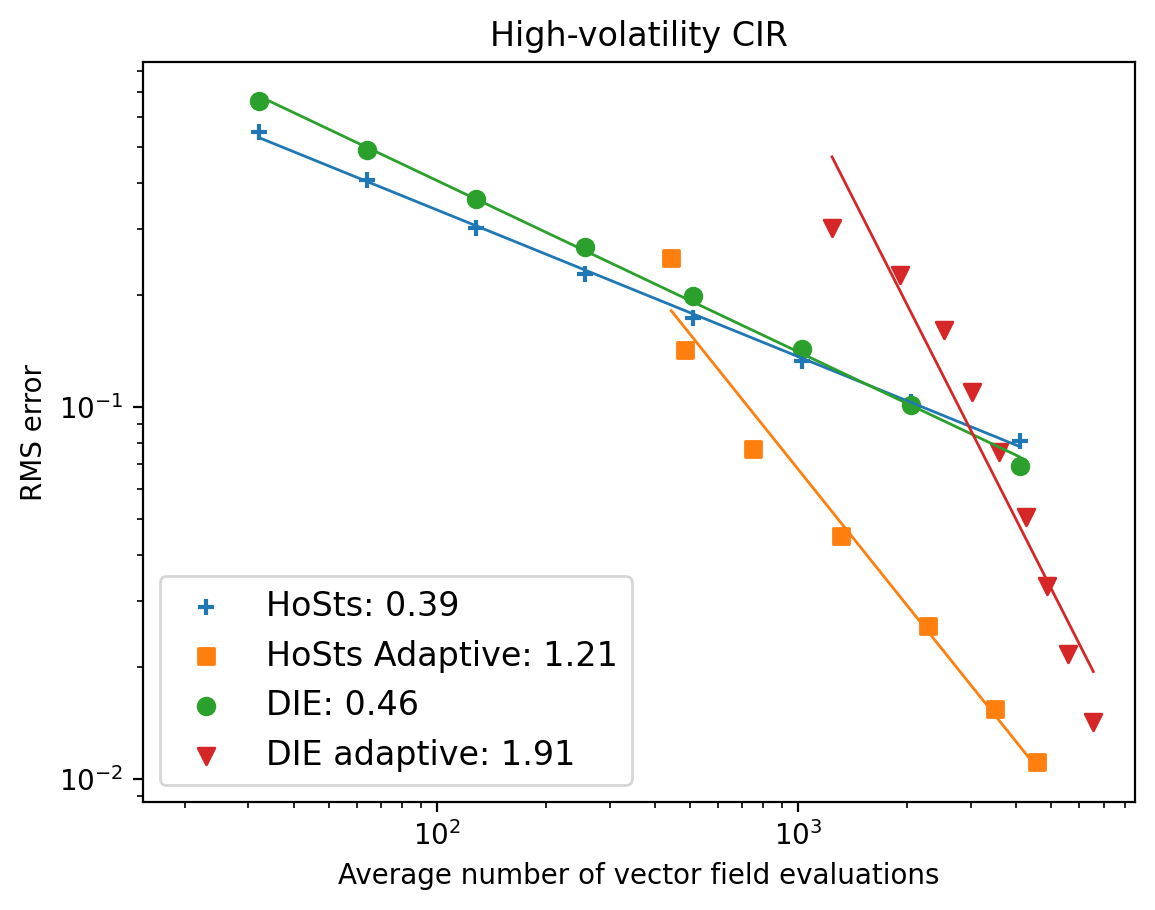

In [8]:
fig = draw_order_multiple(
    [hosts_hard_const, hosts_hard_adap, die_hard_const, die_hard_adap],
    ["HoSts", "HoSts Adaptive", "DIE", "DIE adaptive"],
    "High-volatility CIR",
)
fig.savefig("graphs/high_volatility_cir.png")
fig.savefig("graphs/high_volatility_cir.pdf")

Sample paths for the medium-volatility CIR process
num steps: 1151
num steps: 1106


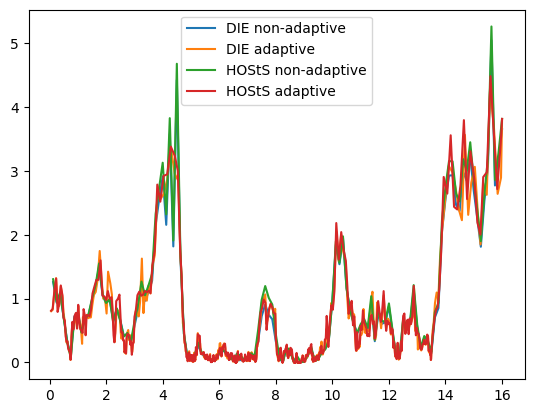

In [10]:
print("Sample paths for the medium-volatility CIR process")

solDIE = diffeqsolve(terms_cir, DIE(), t0, t1, dt0, cir.y0, cir.args, saveat=saveat)
plt.plot(solDIE.ts, solDIE.ys, label="DIE non-adaptive")

controller = CIRController(ctol=2**-6, dtmin=2**-12, dtmax=1)
solDIE_adap = diffeqsolve(
    terms_cir,
    DIE(),
    t0,
    t1,
    1.0,
    cir.y0,
    cir.args,
    saveat=saveat,
    stepsize_controller=controller,
    max_steps=2**15,
)
plt.plot(solDIE_adap.ts, solDIE_adap.ys, label="DIE adaptive")
print(f'num steps: {solDIE_adap.stats["num_accepted_steps"]}')


solCIR = diffeqsolve(
    terms_cir, HOStS(1.0), t0, t1, dt0, cir.y0, cir.args, saveat=saveat
)
plt.plot(solCIR.ts, solCIR.ys, label="HOStS non-adaptive")

solCIR_adap = diffeqsolve(
    terms_cir,
    HOStS(1.0),
    t0,
    t1,
    1.0,
    cir.y0,
    cir.args,
    saveat=saveat,
    stepsize_controller=controller,
    max_steps=2**15,
)
plt.plot(solCIR_adap.ts, solCIR_adap.ys, label="HOStS adaptive")
print(f'num steps: {solCIR_adap.stats["num_accepted_steps"]}')
plt.legend()
plt.show()